<a href="https://colab.research.google.com/github/TobiPrae/customer_segmentation/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [19]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

import gc

# machine learning magic
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print("Libraries successfully imported")

Libraries successfully imported


In [5]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("Everything successfully set up")

Everything successfully set up


# Load Data

In [ ]:
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list[:1]:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: meta_data.xlsx, id: 1QwV131IP74EHaBrKAnlcGk4EaMwBsTHE


In [ ]:
# download demographic data
download_data = drive.CreateFile({'id': '135UcsbUyLcwS16QHa7lFcXHKhuy7HwWF'})
download_data.GetContentFile('azdias.csv')  
df_azdias = pd.read_csv('azdias.csv', engine="python", sep=';')

print(df_azdias.shape)

(891221, 366)


In [ ]:
# download customer data
download_data = drive.CreateFile({'id': '1eDq76GDZLXeonowxPrbwF-EHZwvaENLK'})
download_data.GetContentFile('customers.csv')  
df_customers = pd.read_csv('customers.csv', engine="python", sep=';')

print(df_customers.shape)

(191652, 369)


In [ ]:
# download attribute values and clean them
download_data = drive.CreateFile({'id': '1wFNhCQm7Cv9CGJ7Pm_RbtrJdnLb4zyuC'})
download_data.GetContentFile('attributes_values.xlsx')  
df_attributes_values = pd.read_excel('attributes_values.xlsx', names=["None", "attribute", "description", "value", "meaning"])
df_attributes_values = df_attributes_values.drop(columns=['None'])[1:]
# Forward filling the attribute values df for better filtering/slicing
df_attributes_values["attribute"] = df_attributes_values["attribute"].fillna(method="ffill")
df_attributes_values["description"] = df_attributes_values["description"].fillna(method="ffill")
print(df_attributes_values.shape)

(2258, 4)


In [ ]:
# download attribute information levels and clean them
download_data = drive.CreateFile({'id': '1icPBxHTV0zysKvQSJhSDPDhyH8Qd3uqW'})
download_data.GetContentFile('information_levels_attributes.xlsx')  
df_information_levels = pd.read_excel('information_levels_attributes.xlsx', names=["None", "Information_Level", "attribute", "description", "additional_notes"])
df_information_levels = df_information_levels.drop(columns=["None"])[1:]
print(df_information_levels.shape)

(313, 4)


In [ ]:
# download demographic data
download_data = drive.CreateFile({'id': '1QwV131IP74EHaBrKAnlcGk4EaMwBsTHE'})
download_data.GetContentFile('meta_data.xlsx')  
meta_data = pd.read_excel('meta_data.xlsx')
meta_data = meta_data.iloc[:365, :]
print(meta_data.shape)

(365, 16)


# Functions

In [3]:
def get_description(col):
  '''
  Gets description for given column.

  Args:
  - col: column name

  Returns:
  - description or "No description available."
  '''
  if(df_attributes_values.loc[df_attributes_values["attribute"] == col].shape[0] == 0):
    return "No description available."
  else:
    return df_attributes_values.loc[df_attributes_values["attribute"] == col]["description"].values[0]

In [4]:
def transform_PRAEGENDE_JUGENDJAHRE(x):
  '''
    Transform value for feature PRAEGENDE_JUGENDJAHRE.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x in [1, 2]):
    return 40
  elif(x in [3, 4]):
    return 50
  elif(x in [5, 6, 7]):
    return 60
  elif(x in [8, 9]):
    return 70
  elif(x in [10, 11, 12, 13]):
    return 80
  elif(x in [14, 15]):
    return 90

In [5]:
def transform_CAMEO_INTL_2015(x):
  '''
  Transform value for feature CAMEO_INTL_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(str(x)[0] == '1'):
    return '1'
  if(str(x)[0] == '2'):
    return '2'
  if(str(x)[0] == '3'):
    return '3'
  if(str(x)[0] == '4'):
    return '4'
  if(str(x)[0] == '5'):
    return '5'
  else:
    return np.nan

In [6]:
def transform_CAMEO_DEUG_2015(x):
  '''
  Transform value for feature CAMEO_DEUG_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x == 'X'):
    return np.nan
  else:
    return x

In [7]:
def create_meta_dataframa(df):
  '''
  Creates data frame with meta information.

  Args:
  - Nothing

  Returns:
  - meta_df
  '''
  meta_df = pd.DataFrame(df.columns.tolist())
  meta_df = meta_df.rename(columns={0: "column_name"})
  meta_df["na_percentage"] = meta_df["column_name"].apply(lambda x: round(df[x].isna().sum()/df.shape[0], 4))
  meta_df["dtypes"] =  meta_df["column_name"].apply(lambda x: set(df[x].map(type).tolist()))
  meta_df["n_dtypes"] = meta_df["column_name"].apply(lambda x: len(set(df[x].map(type).tolist())))
  meta_df["unique_valuess"] = meta_df["column_name"].apply(lambda x: len(df[x].value_counts()))
  return meta_df

In [8]:
def transformation_pipeline(df, column_threshold = 0.3, row_threshold = 0.3):

  print(f"shape before: {df.shape}")

  # Drop ID column
  df = df.drop(columns="LNR")
  print("index droped")

  # Drop columns with nan percentage over certain threshold
  meta_df = pd.DataFrame(df.columns.tolist())
  meta_df = meta_df.rename(columns={0: "column_name"})
  meta_df["na_percentage"] = meta_df["column_name"].apply(lambda x: df[x].isna().sum()/df.shape[0])
  drop_columns = meta_df.loc[meta_df["na_percentage"] > column_threshold]["column_name"].tolist()
  df = df.drop(columns=drop_columns)
  print(f"columns with nan threshold of {column_threshold} droped: ")
  print(drop_columns)

  # Drop rows with nan percentage over certain threshold
  df["row_nan_percentage"] = pd.Series(df.index).apply(lambda x: df.iloc[x, :].isna().sum()/df.shape[1])
  df = df.loc[df["row_nan_percentage"] < row_threshold]
  print(f"rows with nan threshold of {row_threshold} droped")  

  ### Drop columns with unknown data types and no description ###

  unknown_cols = meta_data.loc[meta_data["type"] == "Unknown"]["column_name"].tolist()
  df_transformed = df.drop(columns=list(set(unknown_cols).intersection(set(df.columns))))
  print("columns with unknown datatype droped")

  ### Transformation of binary columns ###

  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].replace(2, 0) 
  df_transformed["GREEN_AVANTGARDE"] = df_transformed["GREEN_AVANTGARDE"].fillna(df_transformed["GREEN_AVANTGARDE"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].apply(lambda x: 1 if x == 'W' else (0 if 'O' else x))
  df_transformed["SOHO_KZ"] = df_transformed["SOHO_KZ"].fillna(df_transformed["SOHO_KZ"].mode().values[0])
  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].fillna(df_transformed["ANREDE_KZ"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].fillna(df_transformed["OST_WEST_KZ"].mode().values[0])
  print("binary columns transformed")

  ### Transformation of numerical columns ###

  numerical_columns = meta_data.loc[meta_data["type"] == "Numerical"]["column_name"].tolist()
  for col in list(set(numerical_columns).intersection(set(df_transformed.columns))):
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("numeric columns transformed")

  ### Transformation of ordinal columns ###

  # Transform ordinal columns that have no value or -1 for unknown
  ordinal_no_unknown_cols = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] != 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  for col in ordinal_no_unknown_cols:
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("ordinal columns that have no value for unkown transformed")

  # Transform ordinal colums that have 9 or -1 values for unknow
  ordinal_9_1_cols = meta_data.loc[(meta_data["9 unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  for col in ordinal_9_1_cols:
    df_transformed[col] = df_transformed[col].replace(9, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 9 or -1 values for unknow transformed")

  # Transform ordinal columns that have 0 or -1 values for unknown
  ordinal_0_1_cols = meta_data.loc[(meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  for col in ordinal_0_1_cols:
    df_transformed[col] = df_transformed[col].replace(0, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 0 or -1 values for unknow transformed")

  ### Transformation of categorical features ###

  # Transform categorical columns that have 0 values for unknown
  categorical_0_columns = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Categorical")]["column_name"].tolist()
  for col in categorical_0_columns:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan, 0: np.nan})
  print("categorical columns that have 0 values for unknown transformed")

  # Transform "PRAEGENDE_JUGENDJAHRE"
  df_transformed["PRAEGENDE_JUGENDJAHRE"] = df_transformed["PRAEGENDE_JUGENDJAHRE"].apply(transform_PRAEGENDE_JUGENDJAHRE)
  print('"PRAEGENDE_JUGENDJAHRE" transformed')

  # Transform "ZABEOTYP"
  df_transformed["ZABEOTYP"] = df_transformed["ZABEOTYP"].replace({9: np.nan})
  print('"ZABEOTYP" transformed')

  # Transform "D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"
  cat_temp = ["D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"]
  for col in cat_temp:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan})
  print('"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed')

  # Drop "CAMEO_DEU_2015" and "AGER_TYP"
  df_transformed = df_transformed.drop(columns=["CAMEO_DEU_2015", "AGER_TYP"])
  print('"CAMEO_DEU_2015" and "AGER_TYP" droped')

  # Transform "CAMEO_INTL_2015"
  df_transformed["CAMEO_INTL_2015"] = df_transformed["CAMEO_INTL_2015"].apply(transform_CAMEO_INTL_2015)
  print("CAMEO_INTL_2015 transformed")

  # Transform "CAMEO_DEUG_2015"
  df_transformed["CAMEO_DEUG_2015"] = df_transformed["CAMEO_DEUG_2015"].apply(transform_CAMEO_DEUG_2015)
  print("CAMEO_DEUG_2015 transformed")

  # Create dummies
  cat_cols = meta_data.loc[meta_data["type"] == "Categorical"]["column_name"].tolist()
  print(cat_cols)
  dummy_cols = list(set(cat_cols).intersection(set(df_transformed.columns)))
  print(dummy_cols)
  for col in dummy_cols:
    col_dum_df = pd.get_dummies(df_transformed[col], prefix=col, dummy_na=True)
    df_transformed = pd.concat([df_transformed, col_dum_df], axis=1)

  df_transformed = df_transformed.drop(columns=dummy_cols)
  print("Dummies created")

  # Transform everything to float
  df_transformed = df_transformed.astype(float)

  print(f"shape after: {df_transformed.shape}")
  return df_transformed



# Part 0: Clean and Standardize Data

In [ ]:
df_azdias_transformed = transformation_pipeline(df_azdias)
#meta_df_azdias = create_meta_dataframa(df_azdias_transformed)

shape before: (891221, 366)
index droped
columns with nan threshold of 0.3 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
rows with nan threshold of 0.3 droped
columns with unknown datatype droped
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_2015 transformed
CAMEO_DEUG_2015 transformed
['AGER_TYP', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHR

In [ ]:
#df_customers_transformed = transformation_pipeline(df_customers)
#meta_df_customers = create_meta_dataframa(df_customers_transformed)

In [ ]:
#print(set(df_azdias_transformed.columns).difference(set(df_customers_transformed.columns)))
#print(set(df_customers_transformed.columns).difference(set(df_azdias_transformed.columns)))

In [ ]:
# Scale features
cols = df_azdias_transformed.columns.tolist()
scaled_features = StandardScaler().fit_transform(df_azdias_transformed.values)

# Free some memory
del df_azdias
del df_azdias_transformed
gc.collect()

# Create df
scaled_df = pd.DataFrame(scaled_features, columns=cols)

1048615

In [ ]:
scaled_df.head(5)

,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBE

In [ ]:
start = 0
step = 10000
end = step

for i in range(1, 81):
  print(f"split {i}: {start} - {end}")
  scaled_df.iloc[start:end,:].to_csv(f"df_azdias_scaled_{i}.csv", index=False)
  files = drive.CreateFile({'title' : f"df_azdias_scaled_{i}.csv"})
  files.SetContentFile(f"df_azdias_scaled_{i}.csv")
  files.Upload()
  drive.CreateFile({'id': files.get(f"df_azdias_scaled_{i}.csv")})
  start += step
  end += step
  print("____________________________")
print("upload completed")

# Part 1: Customer Segmentation Report

### PCA Analysis

In [6]:
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
ticker=0
data=dict()
for file1 in file_list:
  if(ticker == 80):
    break
  else:
    data[file1['title']] = file1['id']
  ticker+=1

In [7]:
# Load data
download_data = drive.CreateFile({'id': data[f"df_azdias_scaled_{1}.csv"]})
download_data.GetContentFile(f"df_azdias_scaled_{1}.csv")  
df = pd.read_csv(f"df_azdias_scaled_{1}.csv")

for i in range(2, 81):
  if(i in [10, 20, 30, 40, 50, 60, 70, 80]):
    print(f"Slice {i}")
  download_data = drive.CreateFile({'id': data[f"df_azdias_scaled_{i}.csv"]})
  download_data.GetContentFile(f"df_azdias_scaled_{i}.csv")  
  temp = pd.read_csv(f"df_azdias_scaled_{i}.csv")

  df = pd.concat([df, temp], axis=0)

print(df.shape)
print(sum(df.isna().sum()))
df.head(3)

Slice 10
Slice 20
Slice 30
Slice 40
Slice 50
Slice 60
Slice 70
Slice 80
(785421, 385)
0


,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBE

In [9]:
pca = PCA(.9)

In [10]:
pca.fit(np.array(df))

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca.n_features_

385

In [12]:
pca.n_components_

196

([<matplotlib.axis.XTick at 0x7fd0c6c05898>,
 <a list of 30 Text major ticklabel objects>)

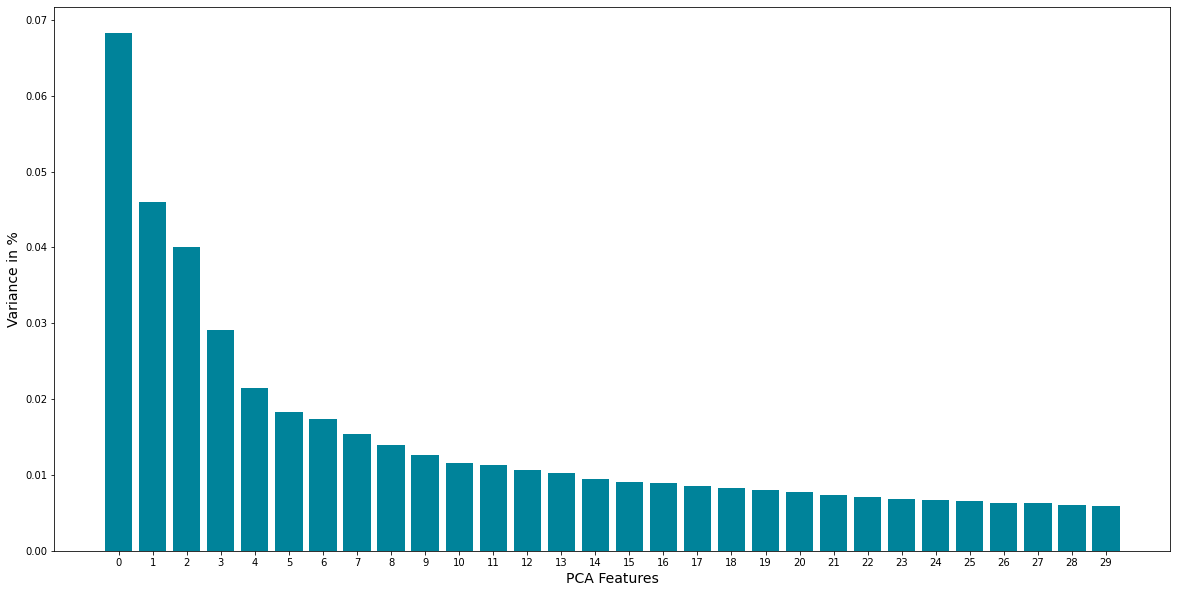

In [13]:
features = range(pca.n_components_)

fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.bar(features[:30], pca.explained_variance_ratio_ [:30], color='#00839A')
plt.xlabel('PCA Features', fontsize=14)
plt.ylabel('Variance in %', fontsize=14)
plt.xticks(features[:30])

In [14]:
pca_components = pd.DataFrame(pca.transform(np.array(df)))

In [15]:
pca_components.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
0,-3.842388,4.268387,4.303276,-4.799002,0.878739,-2.656537,4.263851,1.242280,-0.422030,-1.231880,3.099948,-2.813765,-1.179313,-0.875545,0.010066,0.705545,2.690810,0.204952,-1.036370,2.101852,0.337025,0.181196,1.992743,1.879955,-0.945279,0.068697,1.348754,-1.899966,1.945536,2.541374,-1.482536,-2.177126,-3.380505,2.027928,-0.325455,-2.023487,0.893784,0.836303,2.049812,-0.543144,-0.042332,1.588068,0.890430,-0.530666,1.101743,-0.847992,0.311456,-2.799595,0.072257,1.467789,-0.077566,-0.012191,-0.218463,-1.224919,0.455185,0.971599,-1.033311,1.789385,0.757547,0.840590,-3.075436,1.052483,1.832510,-0.982947,2.768288,2.550479,-1.083347,-0.117059,0.299644,0.377103,0.382504,-1.603547,-1.234400,-0.374161,-1.666588,-1.830755,0.881166,-2.132295,2.945919,-0.229970,0.444125,0.825725,-0.007379,0.951774,1.971134,1.577774,2.750372,-0.770831,-0.495009,-0.021573,1.438301,-1.752052,1.196168,0.826613,3.476629,0.977337,1.699064,-3.371244,-1.039083,-1.265913,1.748815,0.925365,1.831047,0.690739,-0.073482,0.385413,-1.288161,1.001916,0.146605,-1.056356,-1.705754,0.017018,-0.528368,0.958241,-2.594095,1.949358,-1.354970,-0.200612,1.488809,3.044006,1.150905,-1.108878,-1.666083,2.184589,-1.084236,-0.125474,-1.751959,0.948586,-2.242539,-0.265647,1.417116,-0.340216,-2.767801,-1.040818,-1.069150,1.687305,1.086191,-0.079271,-2.094924,0.432031,-0.341442,2.030996,1.242213,-1.304464,0.919484,-0.297888,-0.828515,-0.408008,-0.326256,-0.571697,1.257528,-0.002292,-0.043515,0.659360,0.442771,-0.975385,-0.604718,0.020603,1.040167,-0.281925,0.403947,0.308917,0.438744,0.420402,0.247281,0.727256,0.450820,-0.464603,0.270034,0.090631,1.345783,-0.659526,1.104280,1.505567,0.320173,0.273025,-1.006135,-2.178855,-0.275484,0.476511,0.370881,0.442455,-0.149149,0.869370,-0.025486,-0.572411,0.932880,0.321548,0.320406,0.182583,-1.459859,-0.118992,0.393981,1.135143,-0.047758,0.268097
1,0.132260,3.185990,-0.818140,-1.487219,3.688253,-3.694130,-5.611623,-0.793376,1.725512,0.983931,-2.124021,-1.137178,-2.072795,0.755826,-0.147178,-0.357331,1.871338,0.956760,1.534920,-1.710251,-2.838806,0.099739,-1.255619,0.756257,-0.551216,-0.033581,-0.943600,-0.034913,1.966488,-2.355460,-0.651502,0.722750,-1.949449,-0.652599,-0.079992,-0.558771,0.419472,1.023471,-1.748669,-0.324451,-0.357577,2.268456,1.929088,1.322270,0.902544,-0.940927,0.218650,-0.916237,0.213118,0.338837,0.722671,1.926121,0.764607,0.751070,0.928641,0.803904,-0.805767,-0.142897,-0.966003,-0.598662,1.975341,0.351366,-1.456466,0.782193,-1.113129,1.420796,0.802226,0.219556,0.699038,-0.051655,-0.303320,0.932260,-1.166408,2.001525,0.180112,-0.066574,-0.210520,-1.742800,-0.862052,1.190385,1.696815,0.771705,0.941271,-0.429620,0.702228,-0.117261,-1.756229,-0.007656,0.953479,0.405647,-0.546964,-0.500188,-0.509466,1.404638,0.002041,-1.133728,1.497478,-1.504044,0.053209,0.278413,-0.164427,0.060763,0.280883,0.407571,-0.622827,-0.344302,0.739069,-0.585389,-0.204075,0.508305,-0.126265,-0.441884,0.429132,1.028358,0.898585,-0.658750,0.932341,0.160396,-0.226302,-0.053772,0.631486,-0.468597,0.085721,0.046120,0.085463,-0.580752,0.740792,0.422260,0.663605,1.076135,-0.730212,-1.313327,0.215718,0.276330,0.067804,-1.226588,-0.409322,-0.252907,-0.238406,-0.197636,-0.267251,-1.228883,-0.593568,1.424542,0.095824,0.930527,0.249929,-0.174269,-0.588418,-0.965555,0.284366,-0.524600,-0.503956,-0.011582,0.23

In [17]:
k_range = range(1, 20)
inertia_list = []
for k in k_range:
  start_time = time.time()
  print(f"k = {k}")

  # Build model
  model = KMeans(n_clusters=k)
    
  # Fit model to samples
  model.fit(pca_components.iloc[:,:])

  # Append inertia
  inertia_list.append(model.inertia_)

  end_time = time.time()
  print(f"total time taken model fitting with k = {k}: {end_time - start_time} seconds (inertia {model.inertia_}")
  print("________________________________________________________________________________")

k = 1
total time taken model fitting with k = 1: 21.502275466918945 seconds
______________________________________________________________
k = 2
total time taken model fitting with k = 2: 105.4991569519043 seconds
______________________________________________________________
k = 3
total time taken model fitting with k = 3: 142.47638726234436 seconds
______________________________________________________________
k = 4
total time taken model fitting with k = 4: 198.3704056739807 seconds
______________________________________________________________
k = 5
total time taken model fitting with k = 5: 288.9456117153168 seconds
______________________________________________________________
k = 6
total time taken model fitting with k = 6: 292.826477766037 seconds
______________________________________________________________
k = 7
total time taken model fitting with k = 7: 379.70795345306396 seconds
______________________________________________________________
k = 8
total time taken model fit

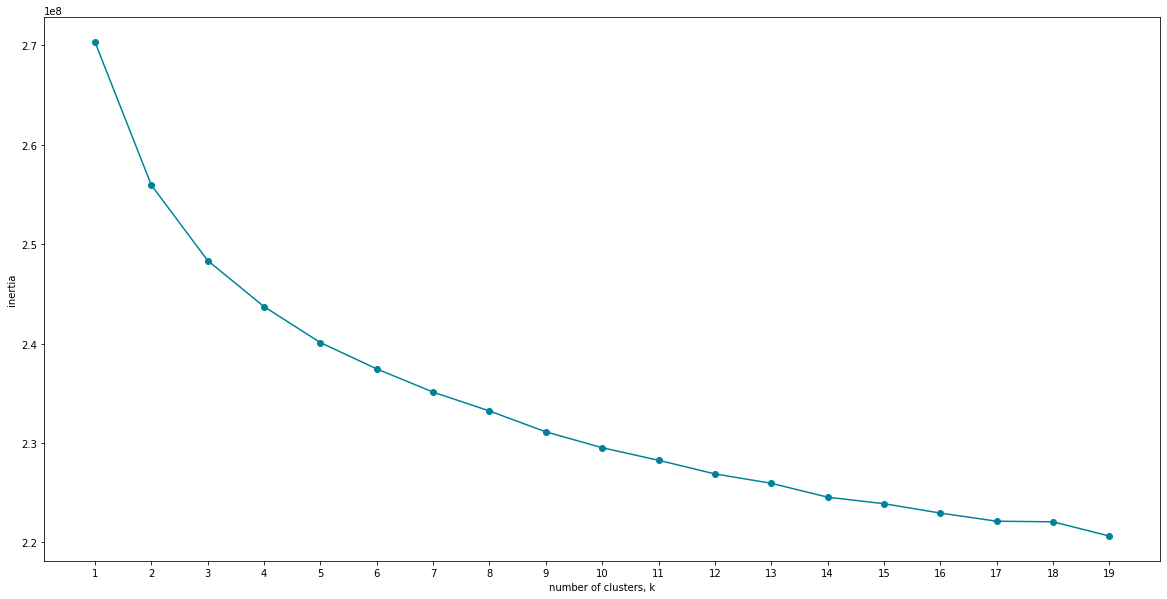

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.plot(ks, inertias, '-o', color='#00839A')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

# Functions

In [ ]:
def engineer_CAMEO_INTL_2015(x):
  '''
  Transform value for feature CAMEO_INTL_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if((x == 'X') | (x == 'XX')):
    return np.nan
  if(str(x)[0] == '1'):
    return '1'
  if(str(x)[0] == '2'):
    return '2'
  if(str(x)[0] == '3'):
    return '3'
  if(str(x)[0] == '4'):
    return '4'
  if(str(x)[0] == '5'):
    return '5'
  else:
    return np.nan

In [ ]:
def engineer_OST_WEST_KZ(x):
  '''
  Transform value for feature OST_WEST_KZ.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x == 'W'):
    return 1
  elif(x == 'O'):
    return 0
  else:
    return np.nan

In [ ]:
def create_meta_dataframa():
  '''
  Creates data frame with meta information.

  Args:
  - Nothing

  Returns:
  - meta_df
  '''
  meta_df = pd.DataFrame(df_azdias.columns.tolist())
  meta_df = meta_df.rename(columns={0: "column_name"})
  meta_df["na_percentage_azdias"] = meta_df["column_name"].apply(lambda x: round(df_azdias[x].isna().sum()/df_azdias.shape[0], 4))
  meta_df["na_percentage_customers"] = meta_df["column_name"].apply(lambda x: round(df_customers[x].isna().sum()/df_customers.shape[0], 4))
  meta_df["dtypes_azdias"] =  meta_df["column_name"].apply(lambda x: set(df_azdias[x].map(type).tolist()))
  meta_df["dtypes_customers"] =  meta_df["column_name"].apply(lambda x: set(df_customers[x].map(type).tolist()))
  meta_df["n_dtypes_azdias"] = meta_df["column_name"].apply(lambda x: len(set(df_azdias[x].map(type).tolist())))
  meta_df["n_dtypes_customers"] = meta_df["column_name"].apply(lambda x: len(set(df_customers[x].map(type).tolist())))
  meta_df["unique_values_azdias"] = meta_df["column_name"].apply(lambda x: len(df_azdias[x].value_counts()))
  meta_df["unique_values_customers"] = meta_df["column_name"].apply(lambda x: len(df_customers[x].value_counts()))
  meta_df["description"] =  meta_df["column_name"].apply(get_description)
  meta_df["action"] = "Keep"
  meta_df["reason"] = "None"
  return meta_df

In [ ]:
def engineer_PRAEGENDE_JUGENDJAHRE(x):
  '''
    Transform value for feature PRAEGENDE_JUGENDJAHRE.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x in [1, 2]):
    return 40
  elif(x in [3, 4]):
    return 50
  elif(x in [5, 6, 7]):
    return 60
  elif(x in [8, 9]):
    return 70
  elif(x in [10, 11, 12, 13]):
    return 80
  elif(x in [14, 15]):
    return 90
  else:
    return np.nan

In [ ]:
def engineer_ALTER_HH(x):
  '''
  Transform value for feature ALTER_HH.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x in [1, 2, 3]):
    return 10
  elif(x in [3, 4, 5]):
    return 20
  elif(x in [6, 7]):
    return 30
  elif(x in [8, 9]):
    return 40
  elif(x in [10, 11]):
    return 50
  elif(x in [12, 13]):
    return 60
  elif(x in [14, 15]):
    return 70
  elif(x in [16, 17]):
    return 80
  elif(x in [18, 19]):
    return 90
  elif(x in [20, 21]):
    return 100
  else:
    return np.nan
